##### Please open 'ReadMe' file

In [1]:
%matplotlib inline
from imp import reload
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.stats import linregress
import seaborn as sns
import curveball

plt.warnings.simplefilter("ignore", category=FutureWarning)

## 1)	Accessing and organizing the data

The data file I use ('Tecan_070416.xlsx') 
contains 24h of O.D measures of each well in a 96 well-plate. 
It is being arranged as DataFrame,
using Curveball's function based on a template file ('G-RG-R.csv'). 
This template was created especially to describe that kind of plate-design as in the Tecan experiment.

In [2]:
''' Arranging experiment's output file as DataFrame '''

plate = pd.read_csv(r"W-WB-B.csv")
df = curveball.ioutils.read_tecan_xlsx('Dana_WB_310716.xlsx', plate=plate, max_time=14)

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:3218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  na_position=na_position)


It is possible to get the growth parameters of the tested strain
by using 'best_values' function from 'fit_model' Curveball module:

In [3]:
''' Getting initial parameters '''

ini_m = curveball.models.fit_model(df[df.Strain=='W'], models=curveball.baranyi_roberts_model.BaranyiRoberts, PLOT=False, PRINT=False)[0]
ini_params = ini_m.best_values
ini_params

{'K': 0.6132222668975702,
 'nu': 0.10000001877720655,
 'q0': 0.067341891397567633,
 'r': 6.1554280613341987,
 'v': 2.8024024262832823,
 'y0': 0.14863577064467148}

In [4]:
t = np.linspace(0,17)

## 2)	Defining a function to reject outliers in upcoming simulation results

In [5]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

In [6]:
K, nu, q0, r, v, y0 = ini_params['K'], ini_params['nu'], ini_params['q0'], ini_params['r'], ini_params['v'], ini_params['y0']
lambda_0 = 1/v * np.log(1 + 1/q0)
print(lambda_0)

0.985991196873


## 3)	Simulation

In [7]:
''' This simulation predicts the effect of pre-growth time on lag duration
according to an extension of ‘Baranyi-Roberts’ model 
and based on curveball‘s parameters optimization of the simulated data.

where:
'q0' - represents the initial adjusment to the enviroment (initial physiological state of the population),
'v' - represents the rate of physiological state adjustment,
'pgds' - Pre-growth durations,
'K', 'nu', 'r' and 'y0' - rest of the growth parameters '''

K, nu, q0, r, v, y0 = ini_params['K'], ini_params['nu'], ini_params['q0'], ini_params['r'], ini_params['v'], ini_params['y0']
lambda_0 = 1/v * np.log(1 + 1/q0)

pgds = np.linspace(0, lambda_0, 50)
lags = np.empty_like(pgds)
stds = np.empty_like(pgds)

for i, pgd in enumerate(pgds):
    lags_per_e = np.empty_like(pgds)
    for e in range(0, 30):
        simulated = curveball.baranyi_roberts_model.baranyi_roberts_function(t, y0, K, r, nu, q0, v) + np.random.normal(loc=0, scale=0.01, size=t.shape)
        simulated[simulated < 0] = 0   
        df = pd.DataFrame({'Time':t, 'OD':simulated})
        m = curveball.models.fit_model(df, models=curveball.baranyi_roberts_model.BaranyiRoberts, PLOT=False, PRINT=False)[0]
        params = m.best_values
        q0_sim, v_sim = params['q0'], params['v']
        lags_per_e[e] = 1/v_sim * np.log(1 + 1 / (q0_sim * np.exp(v_sim * pgd))) #this line stems from an extension of ‘Baranyi-Roberts’ model
        
    lags_per_e = reject_outliers(lags_per_e)
    lags[i] = np.mean(lags_per_e)
    stds[i] = np.std(lags_per_e)
    

displaying simulation results:

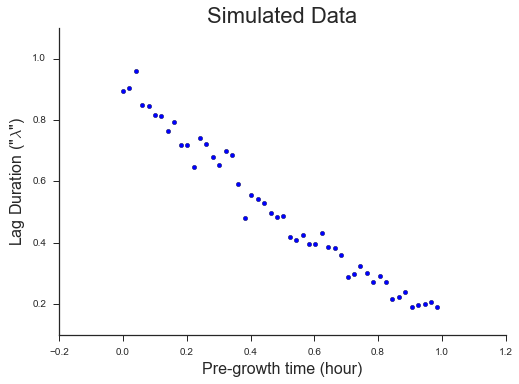

In [8]:
plt.scatter(pgds, lags)

plt.title('Simulated Data', size=22)
plt.xlabel('Pre-growth time (hour)', size=16)
plt.ylabel(r'Lag Duration ("$\lambda$")', size=16)

sns.despine()

## 4)	Curve fitting and other statistical analysis

Trying to find a mathematical functions that fits the simulated data ('1st try', '2nd try' etc):

P-value is 1.82902203684e-38
R^2 is 0.970722065793


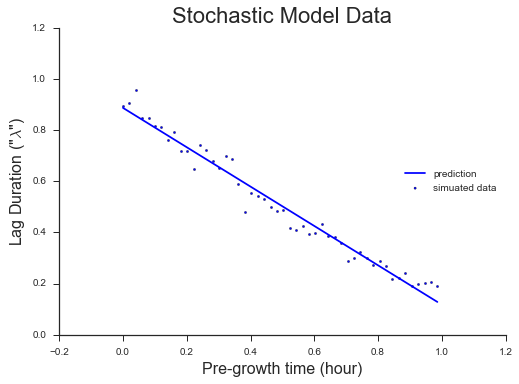

In [15]:
''' linear regression fitting '''

slope, intercept, r_value, p_value, std_err = linregress(pgds, lags)
lag_duration = (intercept + slope * pgds)
print("P-value is", p_value)
print("R^2 is", (r_value)**2)
      
plt.plot(pgds, lag_duration, 'b') # prediction
plt.scatter(pgds, lags, marker='.') # simulated data
plt.title('Stochastic Model Data', size=22)
plt.xlabel('Pre-growth time (hour)', size=16)
plt.ylabel(r'Lag Duration ("$\lambda$")', size=16)
plt.legend(['prediction', 'simuated data'], loc='center right')

#plt.axis([0, 4, 0, 3.3])
sns.despine()
slope

plt.savefig('Lag Duration Vs Pre-growth Time - simulated data.png')

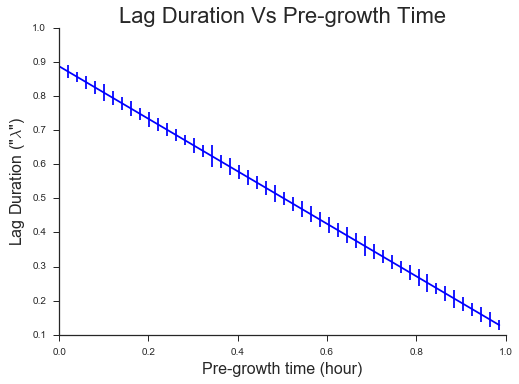

In [10]:
# SEM calc
''' Calculating the standart error mean foreach pre-growth time '''

SEM = [stds/np.sqrt(50) for stds in stds]

plt.errorbar(pgds,lag_duration, SEM, color='b')

plt.title('Lag Duration Vs Pre-growth Time', size=22)
plt.xlabel('Pre-growth time (hour)', size=16)
plt.ylabel(r'Lag Duration ("$\lambda$")', size=16)

sns.despine()

#plt.savefig('Lag Duration Vs Pre-growth Time - SEM.png')

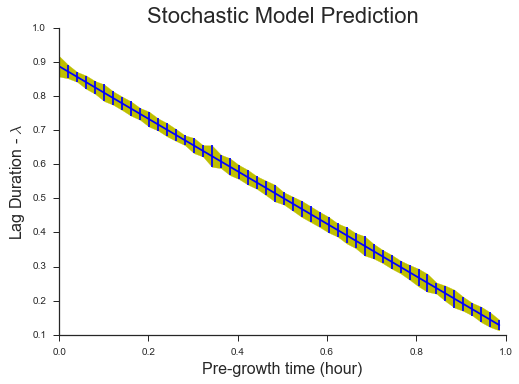

In [14]:
# SEM calc fill between
''' Calculating the standart error mean foreach pre-growth time '''

SEM = [stds/np.sqrt(50) for stds in stds]

plt.errorbar(pgds,lag_duration, SEM, color='b')
plt.fill_between(pgds, lag_duration-SEM, lag_duration+SEM, color='y')

plt.title('Stochastic Model Prediction', size=22)
plt.xlabel('Pre-growth time (hour)', size=16)
plt.ylabel(r'Lag Duration - $\lambda$', size=16)

sns.despine()

#plt.savefig('Lag Duration Vs Pre-growth Time - SEM fill between.png')